In [99]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pylab as pl
import geopandas
from shapely import geometry
from tqdm import tqdm
from statsmodels.tsa.api import Holt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import json
import geopandas as gpd
import folium
from folium import plugins
import branca

In [100]:
df = pd.read_csv("./DC_Properties.csv", index_col=0)
geo = geopandas.read_file('./Neighborhood_Clusters.geojson')

C:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## DC_Properties.csv 数据预处理

- 展示各字段缺失情况，包括占比和图形化展示

<AxesSubplot:>

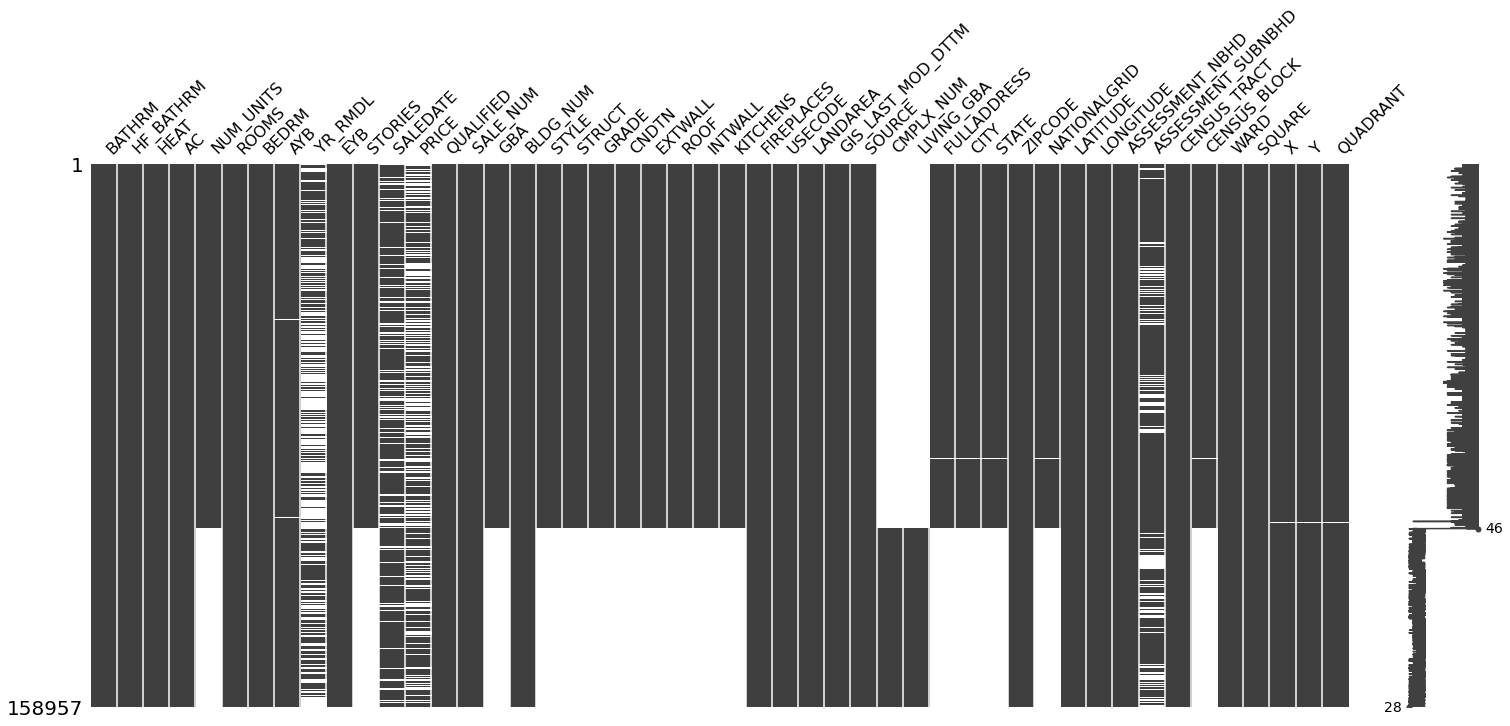

In [104]:
df_percentage = (df.count()/df.shape[0])*100
df_types = df.dtypes
df_info = pd.concat([df_percentage,df_types], axis = 1)
df_info.columns = ['percentage','type']
df_info = df_info.reset_index()
df_info.index = df_info.index+1
df_info = df_info.sort_values(['percentage'], ascending=True)
# print(df_info)
msno.matrix(df)
# df_info[df_info['percentage']<80]

- 显示需要处理的值，缺失值在80%以上的字段进行如下处理：
    - YR_RMDL：更新时间，补充为当前年份
    - ROOM数量类字段：ROOMS是100%，其他的可以不用太关心
    - CENSUS_BLOCK，STORIES，EXTWALL，CONDITION，LIVING_GBA：crime查找最近距离的xy点，使用其block标签标记
    - PRICE：完成以上操作后dropna
    - 其他：丢弃整个字段

In [106]:
df_temp = df
df_temp = df_temp.dropna(subset = ['PRICE'],axis=0)
# 删除丢弃的所有列
droplist = np.array(df_info[df_info['percentage']<80]['index']).tolist()
remainlist = ['PRICE','CENSUS_BLOCK','STORIES','EXTWALL','LIVING_GBA','YR_RMDL']
for remain in remainlist:
    droplist.remove(remain)
df_temp = df_temp.drop(droplist,axis = 1)

In [108]:
# 进行非数值字段的映射
housing = df_temp
housing = housing.dropna(subset = ['SQUARE'], axis=0)
housing = housing[housing['SQUARE']!='PAR ']
housing['SQUARE'] = housing['SQUARE'].apply(int)
housing['SALEDATE'] = pd.to_datetime(housing['SALEDATE'],infer_datetime_format=True)
housing['GIS_LAST_MOD_DTTM'] = pd.to_datetime(housing['GIS_LAST_MOD_DTTM'],infer_datetime_format=True)
housing['SALEDATE_year'] = housing['SALEDATE'].dt.year
housing['SALEDATE_month'] = housing['SALEDATE'].dt.month
housing['SALEDATE_day'] = housing['SALEDATE'].dt.day
# housing['SALEDATE_hour'] = housing['SALEDATE'].dt.hour
housing['GIS_LAST_MOD_DTTM_year'] = housing['GIS_LAST_MOD_DTTM'].dt.year
housing['GIS_LAST_MOD_DTTM_month'] = housing['GIS_LAST_MOD_DTTM'].dt.month
housing['GIS_LAST_MOD_DTTM_day'] = housing['GIS_LAST_MOD_DTTM'].dt.day
housing['GIS_LAST_MOD_DTTM_hour'] = housing['GIS_LAST_MOD_DTTM'].dt.hour
housing = housing.drop(columns=['SALEDATE','GIS_LAST_MOD_DTTM'])
ref = housing

housing = df_temp
housing = housing.dropna(subset = ['SQUARE'], axis=0)
housing = housing[housing['SQUARE']!='PAR ']
housing['SQUARE'] = housing['SQUARE'].apply(int)
housing['SALEDATE'] = pd.to_datetime(housing['SALEDATE'],infer_datetime_format=True)
housing['GIS_LAST_MOD_DTTM'] = pd.to_datetime(housing['GIS_LAST_MOD_DTTM'],infer_datetime_format=True)
housing['SALEDATE_year'] = housing['SALEDATE'].dt.year
housing['SALEDATE_month'] = housing['SALEDATE'].dt.month
housing['SALEDATE_day'] = housing['SALEDATE'].dt.day
housing['GIS_LAST_MOD_DTTM_year'] = housing['GIS_LAST_MOD_DTTM'].dt.year
housing['GIS_LAST_MOD_DTTM_month'] = housing['GIS_LAST_MOD_DTTM'].dt.month
housing['GIS_LAST_MOD_DTTM_day'] = housing['GIS_LAST_MOD_DTTM'].dt.day
housing['GIS_LAST_MOD_DTTM_hour'] = housing['GIS_LAST_MOD_DTTM'].dt.hour
housing = housing.drop(columns=['SALEDATE','GIS_LAST_MOD_DTTM'])
# 非数值型字段（表示不同类别的）对应数值编码
cols = housing.select_dtypes(exclude = ['int64', 'float64']).columns
for c in cols:
    class_mapping = {label: idx for idx, label in enumerate(np.unique(ref[c].dropna()))}
    housing[c] = housing[c].map(class_mapping)
housing = housing.reset_index(drop = True)
housing['YR_RMDL'] = housing['YR_RMDL'].fillna(2021)

<AxesSubplot:>

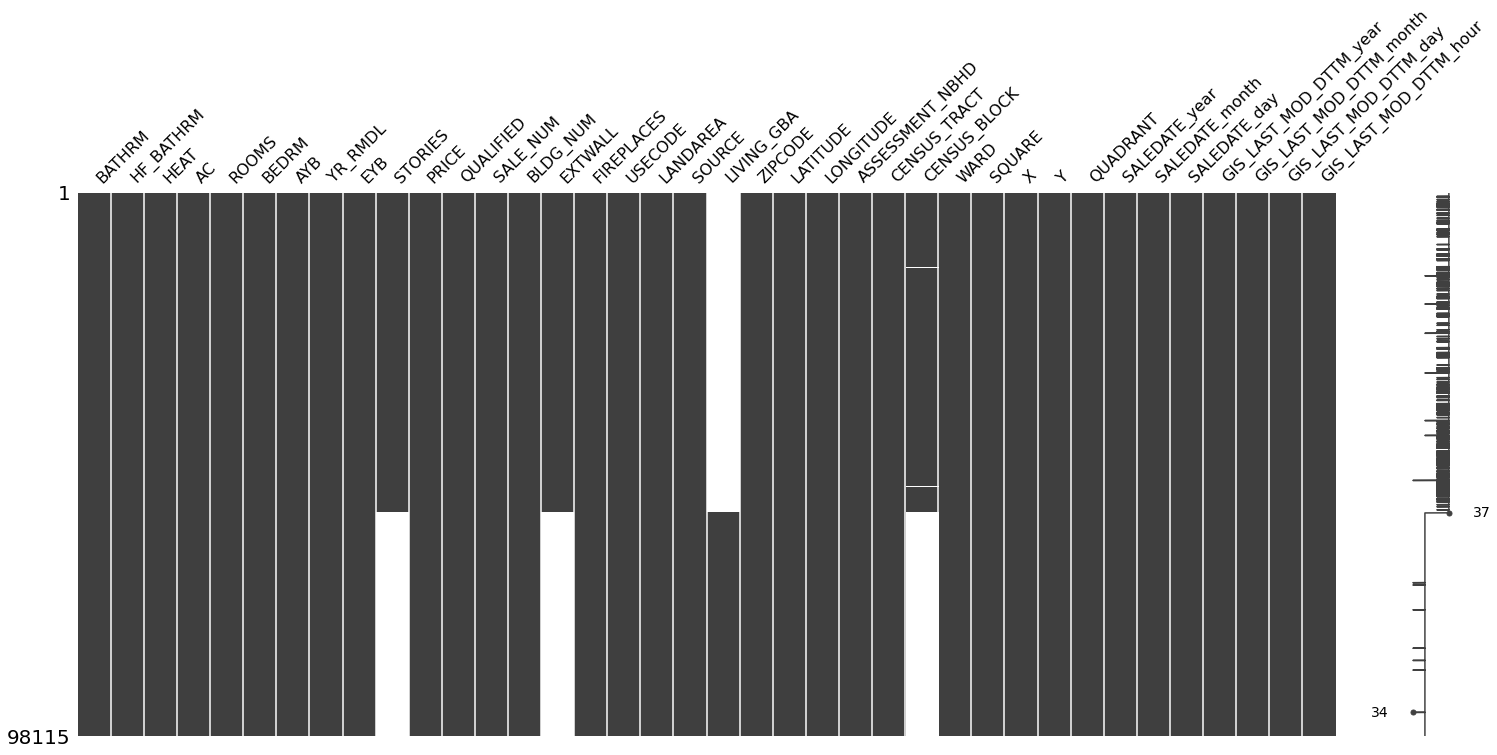

In [109]:
msno.matrix(housing)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [12:09<00:00, 182.33s/it]


<AxesSubplot:>

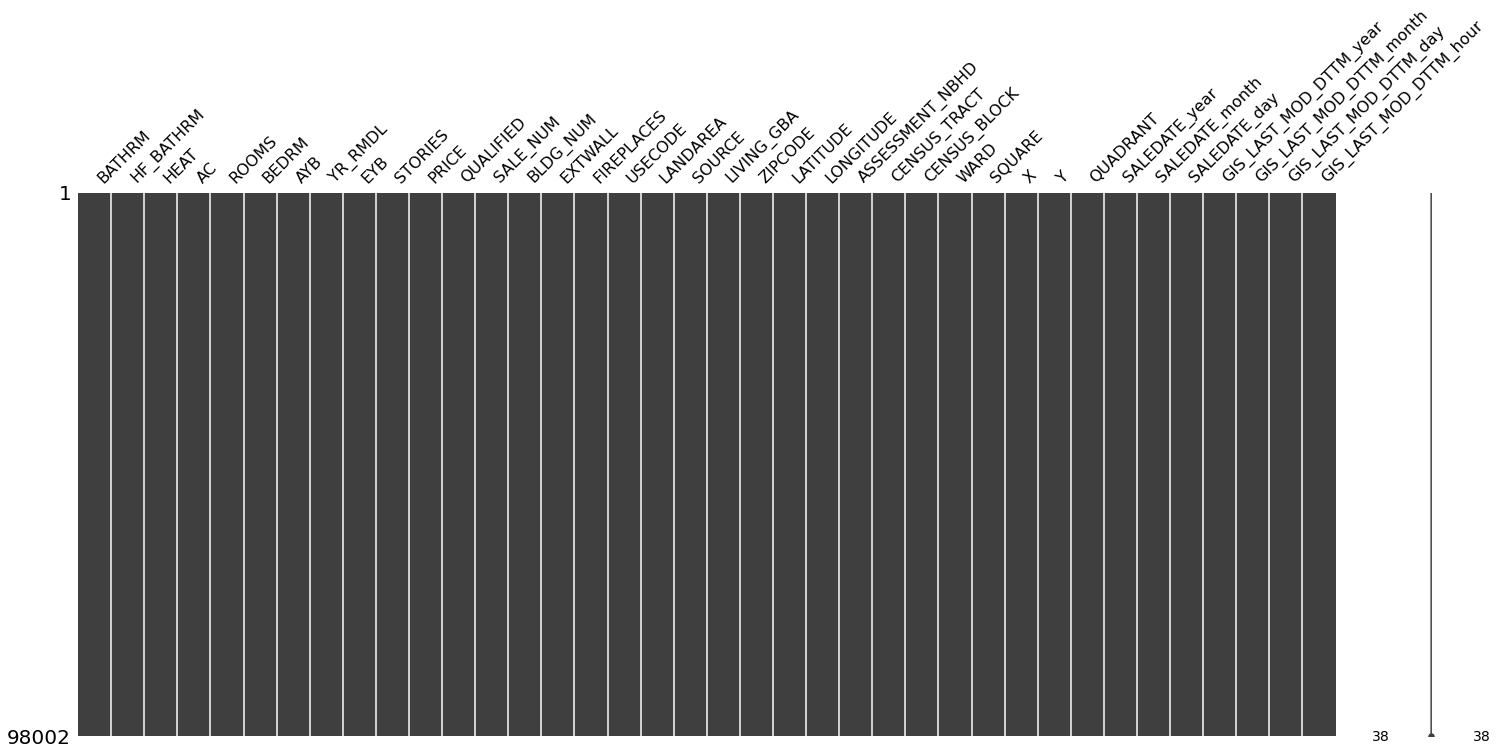

In [112]:
# KNN实现数据填充
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)
knnimputelist = ['STORIES','CENSUS_BLOCK','EXTWALL','LIVING_GBA']
housing = housing
for c in tqdm(knnimputelist):
    temp = housing[['X','Y',c]]
#   print(temp[temp.isnull().T.any()])
    temp = imputer.fit_transform(temp)
    housing[c] = temp[:,2]
#   print(temp[temp[c].isnull()])
# msno.matrix(housing)
housing = housing.dropna(axis = 0)
# msno.matrix(housing)
housing.to_csv("./housing.csv",index = False)
housing = pd.read_csv("./housing.csv",index_col = False)
msno.matrix(housing)

- 按照一定范围内的犯罪数量作为犯罪字段

In [ ]:
crime = pd.read_csv("./DC_Crime.csv", index_col=None)
housing = pd.read_csv("./housing.csv", index_col=None)
threshold = 0.000001
temp = crime[['LONGITUDE','LATITUDE']]
def crime_count(longitude,latitude):
    temp['lo'] = longitude
    temp['la'] = latitude
    temp['distance'] = (temp['LONGITUDE']-temp['lo'])**2+(temp['LATITUDE']-temp['la'])**2
    return (temp[temp['distance']<threshold].count()[0])

housing['crime_count'] = housing.apply(lambda x:crime_count(x['LONGITUDE'],x['LATITUDE']),axis=1)
housing.to_csv("./housing_crime.csv",index = None)

- 生成CLUSTER列

In [3]:
housing = pd.read_csv("./housing_crime.csv", index_col=None)
def findCluster(x,y):
    temp = geo
    temp['x'] = x
    temp['y'] = y
    temp['label'] = temp['geometry'].contains(geometry.Point([x,y]))
    result = np.array(temp[temp['label']==True]['NAME'])[0]
    return result
housing['CLUSTER'] = housing.apply(lambda x:findCluster(x['X'],x['Y']),axis = 1)
housing['CLUSTER_NUM'] = housing['CLUSTER'].str.extract('([0-9]+)').astype('int8')
housing.to_csv("./housing_crime_cluster.csv",index = None)

- load处理好的数据，并且去除无用字段:
    - Cluster已经有cluster_num代替
    - GIS相关时间 全部一样，不具有参考价值

In [56]:
housing = pd.read_csv("./housing_crime_cluster.csv")
housing = housing.drop(columns = ['CLUSTER','GIS_LAST_MOD_DTTM_year','GIS_LAST_MOD_DTTM_month','GIS_LAST_MOD_DTTM_day','GIS_LAST_MOD_DTTM_hour'],axis = 1)
housing.to_csv("./housing_final.csv",index = None)

(*由于数据处理过程过长，一下代码直接load处理完成的值*)

In [58]:
housing = pd.read_csv("./housing_final.csv",index_col = None)

- 异常值剔除，采用箱线图剔除方法

In [4]:
def box_plot_outlier(data):
#     deg = pd.Series(data)
    deg = data
    deg = data
    mean = np.mean(deg)
    var = np.var(deg)
    percentile = np.percentile(deg, (25, 50, 75), interpolation='midpoint')
    #以下为箱线图的五个特征值
    Q1 = percentile[0]#上四分位数
    Q3 = percentile[2]#下四分位数
    IQR = Q3 - Q1#四分位距
    ulim = Q3 + 1.5*IQR#上限 非异常范围内的最大值
    llim = Q1 - 1.5*IQR#下限 非异常范围内的最小值
    new_deg = []
    for i in range(len(deg)):
        if(llim<deg[i] and deg[i]<ulim):
            new_deg.append(deg[i])
        else:
            new_deg.append(np.nan)
    return pd.DataFrame(new_deg)
inHousing = housing
inHousing['PRICE'] = box_plot_outlier(inHousing['PRICE'])
inHousing = inHousing.dropna()

归一化处理

In [6]:
def autoNorm(data): #传入一个矩阵
    mins = data.min(0) #返回data矩阵中每一列中最小的元素，返回一个列表
    maxs = data.max(0) #返回data矩阵中每一列中最大的元素，返回一个列表
    ranges = maxs - mins #最大值列表 - 最小值列表 = 差值列表
    normData = np.zeros(np.shape(data)) #生成一个与 data矩阵同规格的normData全0矩阵，用于装归一化后的数据
    row = data.shape[0] #返回 data矩阵的行数
    normData = data - np.tile(mins,(row,1)) #data矩阵每一列数据都减去每一列的最小值
    normData = normData / np.tile(ranges,(row,1)) #data矩阵每一列数据都除去每一列的差值(差值 = 某列的最大值- 某列最小值)
    return normData,mins,ranges

In [7]:
normHousing,mins,ranges = autoNorm(inHousing)

- 地形图展示不同cluster房价均值

In [113]:
dc = gpd.read_file("Neighborhood_Clusters.geojson")
dc['NAME'] = dc['NAME'].str.extract('([0-9]+)').astype('int8')
price = inHousing.groupby(['CLUSTER_NUM'])[ 'PRICE'].mean().astype('int64')
price.index.name = 'index'

In [114]:
# merge two dataset
dc = dc.merge(price, left_on='NAME', right_on='index', how='left')
# dc = dc.drop('day', axis=1)
mean = df['PRICE'].mean()
dc['PRICE'] = dc['PRICE'].fillna(mean)
# dc.head()

OBJECTID                  WEB_URL  NAME  \
0         1  http://planning.dc.gov/    39   
1         2  http://planning.dc.gov/    38   
2         3  http://planning.dc.gov/    36   
3         4  http://planning.dc.gov/    27   
4         5  http://planning.dc.gov/    32   

                                           NBH_NAMES  Shape_Length  \
0   Congress Heights, Bellevue, Washington Highlands  10711.668010   
1                           Douglas, Shipley Terrace   8229.486324   
2  Woodland/Fort Stanton, Garfield Heights, Knox ...   4746.344457   
3                          Near Southeast, Navy Yard   7286.968902   
4      River Terrace, Benning, Greenway, Dupont Park  11251.012821   

     Shape_Area      TYPE                                           geometry  \
0  4.886463e+06  Original  POLYGON ((-76.99402 38.84520, -76.99471 38.845...   
1  2.367958e+06  Original  POLYGON ((-76.97472 38.85287, -76.97499 38.853...   
2  1.119573e+06  Original  POLYGON ((-76.96877 38.86067, -76.96907 38.860...   
3  1.619167e+06  Original  POLYGON ((-76.98726 38.87712, -76.98860 38.877...   
4  4.286254e+06  Original  POLYGON ((-76.93760 38.88996, -76.93783 38.890...   

      PRICE  
0  196766.0  
1  248737.0  
2  176752.0  
3  624777.0  
4  188922.0

In [71]:
# centroid=dc.geometry.centroid ## identifies the center point of all the neighborhood shapes 
# m=folium.Map(location=[centroid.y.mean(), centroid.x.mean()], zoom_start=12) ## initiaes a map based on the centroid
# m

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [14]:
variable = 'PRICE' 
name = '# average price'
print(name, "colorscale")
print("Min:",dc[variable].min())
print("Max:",dc[variable].max())   
colorscale = branca.colormap.linear.YlOrRd_09.scale(dc[variable].min(), dc[variable].max()) 
colorscale

# average price colorscale
Min: 0.0
Max: 708468.0


In [15]:
# create df with neighborhood name and variable of interest, sorted from largest to smallest
df = dc[['NAME', variable]].sort_values(by = variable, ascending = False) 
    
# reset index so that the largest value corresponds to row 0 and smallest to row 136
df.reset_index(inplace = True)
leg_brks = list(df[df.index.isin([0,4,9,19,29,49])][variable]) # identify the value of the var by index position
    
# make the smallest value of the scale be 0
leg_brks.append(0)
leg_brks.sort() # sort from smallest to largest
print("Quantiles:", leg_brks)

Quantiles: [0, 241232.0, 411829.0, 515342.0, 624777.0, 708468.0]


In [16]:
print(name, "colorscale")

colorscale = branca.colormap.linear.YlOrRd_09.scale(dc[variable].min(), dc[variable].max()) 
colorscale = colorscale.to_step(n = 6, quantiles = leg_brks) ## sets quantile breaks 
colorscale.caption = name ## adds name for legend
    
colorscale

# average price colorscale


In [17]:
variable = 'PRICE' #active restaurants in Washington, DC as of 9/2019
name = '# average price'


folium.GeoJson(dc, ## GeoPandas dataframe
               name="Washington DC",
                   
               ## controls the fill of the geo regions; applying colorscale based on variable
               style_function=lambda x: {"weight":1
                                         , 'color': '#545453'
                                         ## if variable is 0 map is a very light grey
                                         ## else colorscale applies based on variable
                                         , 'fillColor':'#9B9B9B' if x['properties'][variable] == 0 
                                         else colorscale(x['properties'][variable])
                                         ## similarly opacity is increased if value is 0
                                         , 'fillOpacity': 0.2 if x['properties'][variable] == 0 
                                         else 0.5},
                   
               ## changes styling of geo regions upon hover
               highlight_function=lambda x: {'weight':3, 'color':'black', 'fillOpacity': 1}, 
               
                ## tooltip can include information from any column in the GeoPandas dataframe   
                tooltip=folium.features.GeoJsonTooltip(
                fields=['NBH_NAMES', 'NAME', variable],
                aliases=['NBH_NAMES:', 'Cluster:', name])
              ).add_to(m)

## add colorscale to map so that it appears as the legend
colorscale.add_to(m)

m

预测房价趋势

In [23]:
test = inHousing[['SALEDATE_year','SALEDATE_month','SALEDATE_day','CLUSTER_NUM','PRICE']]
test['SALEDATE_year'] = test['SALEDATE_year'].astype('int64').apply(str)
test['SALEDATE_month'] = test['SALEDATE_month'].astype('int64').apply(str)
test['SALEDATE_day'] = test['SALEDATE_day'].astype('int64').apply(str)
test['SALEDATE'] = test['SALEDATE_year']+"-"+test['SALEDATE_month']+'-'+test['SALEDATE_day']
test['SALEDATE'] = pd.to_datetime(test['SALEDATE'],format = '%Y-%m-%d')
test.index = test['SALEDATE']
test = test[['PRICE']]
test = test[test.index.year>=1992]
test = test.resample('M').mean()
test = test.fillna(method = 'ffill')

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

### 霍尔特(Holt)线性趋势法预测未来房价（按月为单位）

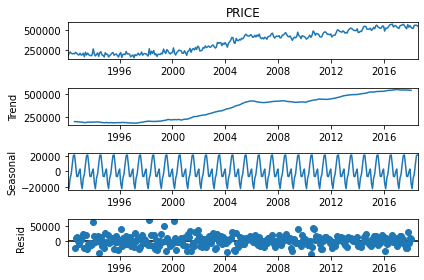

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  app.launch_new_instance()


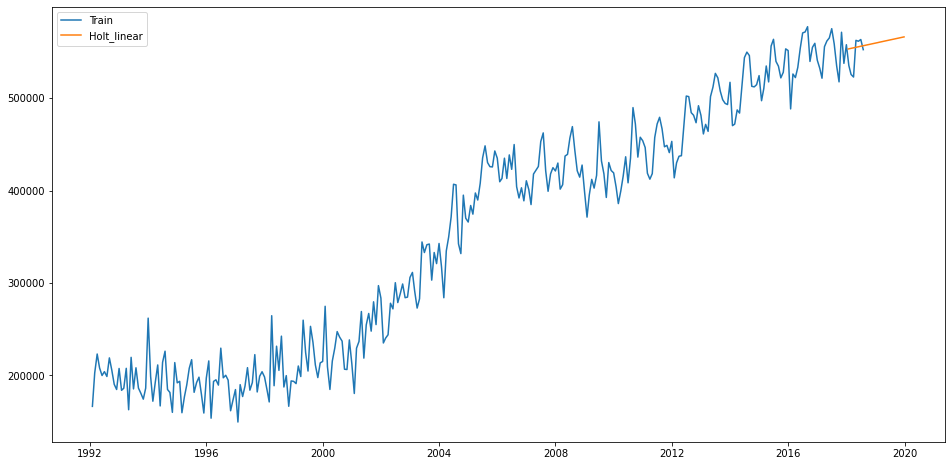

In [31]:
sm.tsa.seasonal_decompose(test['PRICE']).plot()
result = sm.tsa.stattools.adfuller(test['PRICE'])
plt.show()
y_hat_avg = test.copy()
fit = Holt(np.asarray(test['PRICE'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit.forecast(len(test))
y_hat_avg.index = y_hat_avg.index+datetime.timedelta(days=26*365)
y_hat_avg = y_hat_avg.head(24)
plt.figure(figsize=(16, 8))
plt.plot(test['PRICE'], label='Train')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [32]:
y_hat_avg

PRICE    Holt_linear
SALEDATE                                
2018-01-24  166469.318841  553286.356282
2018-02-22  202695.645161  553854.312033
2018-03-25  223141.413333  554422.267785
2018-04-24  208040.269663  554990.223536
2018-05-25  199875.024390  555558.179288
2018-06-24  204084.817308  556126.135040
2018-07-25  198805.976744  556694.090791
2018-08-25  218942.691358  557262.046543
2018-09-24  205888.782609  557830.002294
2018-10-25  190297.656250  558397.958046
2018-11-24  184734.925926  558965.913797
2018-12-25  207489.009709  559533.869549
2019-01-25  183874.960784  560101.825301
2019-02-22  186097.947368  560669.781052
2019-03-25  207650.185185  561237.736804
2019-04-24  162817.986301  561805.692555
2019-05-25  219534.421053  562373.648307
2019-06-24  185380.291667  562941.604058
2019-07-25  208231.333333  563509.559810
2019-08-25  186259.794872  564077.515562
2019-09-24  180686.430380  564645.471313
2019-10-25  174289.955882  565213.427065
2019-11-24  186213.083333  565781.382816
2019-12-25  261961.236842  566349.338568

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


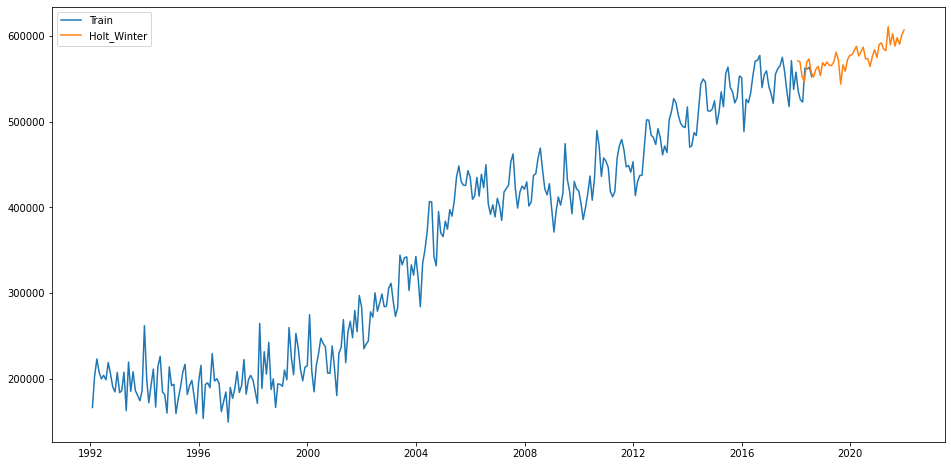

In [88]:
from statsmodels.tsa.api import ExponentialSmoothing
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(test['PRICE']), seasonal_periods=50, trend='add', seasonal='add', ).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
y_hat_avg.index = y_hat_avg.index+datetime.timedelta(days=26*365)
y_hat_avg = y_hat_avg.head(12*4)
plt.figure(figsize=(16, 8))
plt.plot(test['PRICE'], label='Train')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [72]:
y_hat_avg

PRICE    Holt_Winter
SALEDATE                                
2018-01-24  166469.318841  571134.850044
2018-02-22  202695.645161  570139.681947
2018-03-25  223141.413333  552063.571391
2018-04-24  208040.269663  547331.388062
2018-05-25  199875.024390  569724.363029
2018-06-24  204084.817308  573224.182227
2018-07-25  198805.976744  557356.915378
2018-08-25  218942.691358  552259.134137
2018-09-24  205888.782609  561083.592377
2018-10-25  190297.656250  564674.693243
2018-11-24  184734.925926  553865.431179
2018-12-25  207489.009709  568984.907025
2019-01-25  183874.960784  565337.804010
2019-02-22  186097.947368  569771.249402
2019-03-25  207650.185185  565870.591347
2019-04-24  162817.986301  565586.546522
2019-05-25  219534.421053  570072.149649
2019-06-24  185380.291667  581247.619902
2019-07-25  208231.333333  572037.038742
2019-08-25  186259.794872  543925.022542
2019-09-24  180686.430380  566349.462669
2019-10-25  174289.955882  558998.135154
2019-11-24  186213.083333  572447.993302
2019-12-25  261961.236842  577431.959940
2020-01-25  198768.093750  578312.999520
2020-02-22  172040.000000  582788.690246
2020-03-24  192977.369863  588033.134319
2020-04-23  211296.523256  576746.903034
2020-05-24  166939.329268  581817.158714
2020-06-23  214080.000000  587145.307038
2020-07-24  226207.181818  573529.688399
2020-08-24  184734.444444  573475.528008
2020-09-23  181510.022222  564610.257139
2020-10-24  159981.896552  576219.967196
2020-11-23  213859.552941  584155.905294
2020-12-24  191971.949367  574909.061249
2021-01-24  193584.000000  590164.844281
2021-02-21  159579.473684  591962.920603
2021-03-24  176742.241379  585089.366619
2021-04-23  189878.170213  582915.806619
2021-05-24  207745.465517  610941.130283
2021-06-23  217007.322581  589631.342099
2021-07-24  181680.151515  602698.087073
2021-08-24  192226.936937  588238.797932
2021-09-23  198067.619565  598198.284978
2021-10-24  179334.820896  590379.946202
2021-11-23  159247.121622  601138.258674
2021-12-24  197066.421053  606977.556269

In [65]:
housing = inHousing
housing = pd.read_csv("./housing_final.csv",index_col = None)

In [66]:
housing

BATHRM  HF_BATHRM  HEAT  AC  ROOMS  BEDRM     AYB  YR_RMDL   EYB  \
0           4          0    12   2      8      4  1910.0   1988.0  1972   
1           3          1     7   2      9      5  1910.0   2009.0  1984   
2           3          1     7   2      8      5  1900.0   2003.0  1984   
3           3          2     7   2     10      5  1913.0   2021.0  1972   
4           3          1     7   2      8      4  1906.0   2011.0  1972   
...       ...        ...   ...  ..    ...    ...     ...      ...   ...   
97997       3          1     5   2      5      3  1938.0   2006.0  1938   
97998       1          0     5   2      3      1  1938.0   2006.0  1938   
97999       1          0     5   2      4      2  1938.0   2006.0  1938   
98000       2          0     5   2      4      2  1920.0   2007.0  1920   
98001       1          0    12   2      2      0  1965.0   2021.0  1965   

       STORIES  ...  WARD  SQUARE          X          Y  QUADRANT  \
0          3.0  ...     1     152 -77.040429  38.914881         1   
1          3.0  ...     1     152 -77.040429  38.914881         1   
2          3.0  ...     1     152 -77.040429  38.914881         1   
3          4.0  ...     1     152 -77.040429  38.914881         1   
4          3.0  ...     1     152 -77.040429  38.914881         1   
...        ...  ...   ...     ...        ...        ...       ...   
97997      3.0  ...     5     477 -77.019422  38.911848         1   
97998      3.0  ...     5     477 -77.019422  38.911848         1   
97999      3.0  ...     5     477 -77.019422  38.911848         1   
98000      3.0  ...     5     477 -77.019422  38.911848         1   
98001      2.0  ...     5     504 -77.018232  38.872961         3   

       SALEDATE_year  SALEDATE_month  SALEDATE_day  crime_count  CLUSTER_NUM  
0             2003.0            11.0          25.0          345            6  
1             2016.0             6.0          21.0          198            6  
2             2006.0             7.0          12.0          191            6  
3             2010.0             2.0          26.0          278            6  
4             2011.0             9.0          29.0          403            6  
...              ...             ...           ...          ...          ...  
97997         2009.0            11.0          12.0          231            7  
97998         2015.0             4.0           3.0          231            7  
97999         2013.0            10.0           4.0          231            7  
98000         2008.0             9.0          30.0          231            7  
98001         2015.0             4.0          14.0           75            9  

[98002 rows x 36 columns]

In [67]:
from sklearn.decomposition import PCA
# 提取变量值和目标值
X = housing.drop(['PRICE'],axis=1)
Y = housing['PRICE']
# 降维
# 提取变量值和目标值
pca = PCA(n_components=10)
pca.fit(X)
X = pd.DataFrame(pca.fit_transform(X))
# print(pca.explained_variance_ratio_)

载入评价指标

In [73]:
import sklearn.metrics as m

In [76]:
from sklearn.model_selection import train_test_split
# 30%用于测试集，70%用于训练集
X_train,X_test,y_train,y_test= train_test_split(X,Y,test_size=0.3,random_state=0)

决策树回归

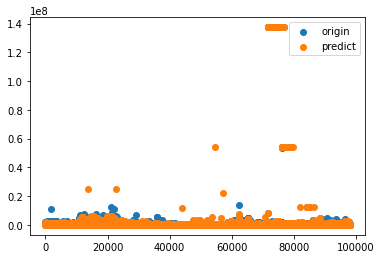

In [83]:
from sklearn.tree import DecisionTreeRegressor
# 构建决策树模型并预测
reg1 = DecisionTreeRegressor(max_depth=10)
reg1.fit(X_train,y_train)
predict_value = reg1.predict(X_test)
# 绘制图像
plt.figure()
plt.scatter(X_test.index.tolist(), y_test.tolist(), label = "origin")
plt.scatter(X_test.index.tolist(), predict_value.tolist(), label = "predict")
plt.legend()

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict = predict_value
y = y_test
print(f'mean squared error is: {mean_squared_error(y,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y,y_predict)}')
print(f'R Squared is: {r2_score(y,y_predict)}')

mean squared error is: 680449180443.0328
mean absolute error is: 181212.9198293221
R Squared is: 0.9854327041906179


随机森林回归

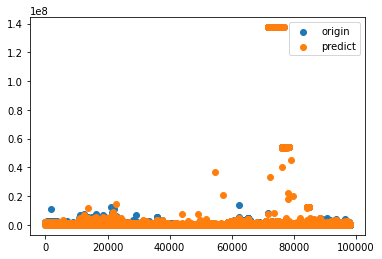

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# # 提取变量值和目标值
# X = housing.drop(['PRICE'],axis=1)
# Y = housing['PRICE']
# 构建决策树模型并预测
forest_reg = RandomForestRegressor(random_state=41)
forest_reg.fit(X_train,y_train)
predict_value = forest_reg.predict(X_test)
# 绘制图像
plt.figure()
plt.scatter(X_test.index.tolist(), y_test.tolist(), label = "origin")
plt.scatter(X_test.index.tolist(), predict_value.tolist(), label = "predict")
plt.legend()

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict = predict_value
y = y_test
print(f'mean squared error is: {mean_squared_error(y,y_predict)}')
print(f'mean absolute error is: {mean_absolute_error(y,y_predict)}')
print(f'R Squared is: {r2_score(y,y_predict)}')

mean squared error is: 339981955684.97656
mean absolute error is: 103303.37952723804
R Squared is: 0.9927215465009589


根据两种回归模型

绘制相关性矩阵热力图

<AxesSubplot:>

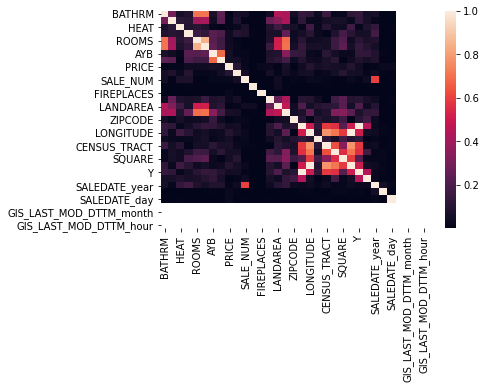

In [74]:
housing_cor = housing.corr().abs()
sns.heatmap(housing_cor)

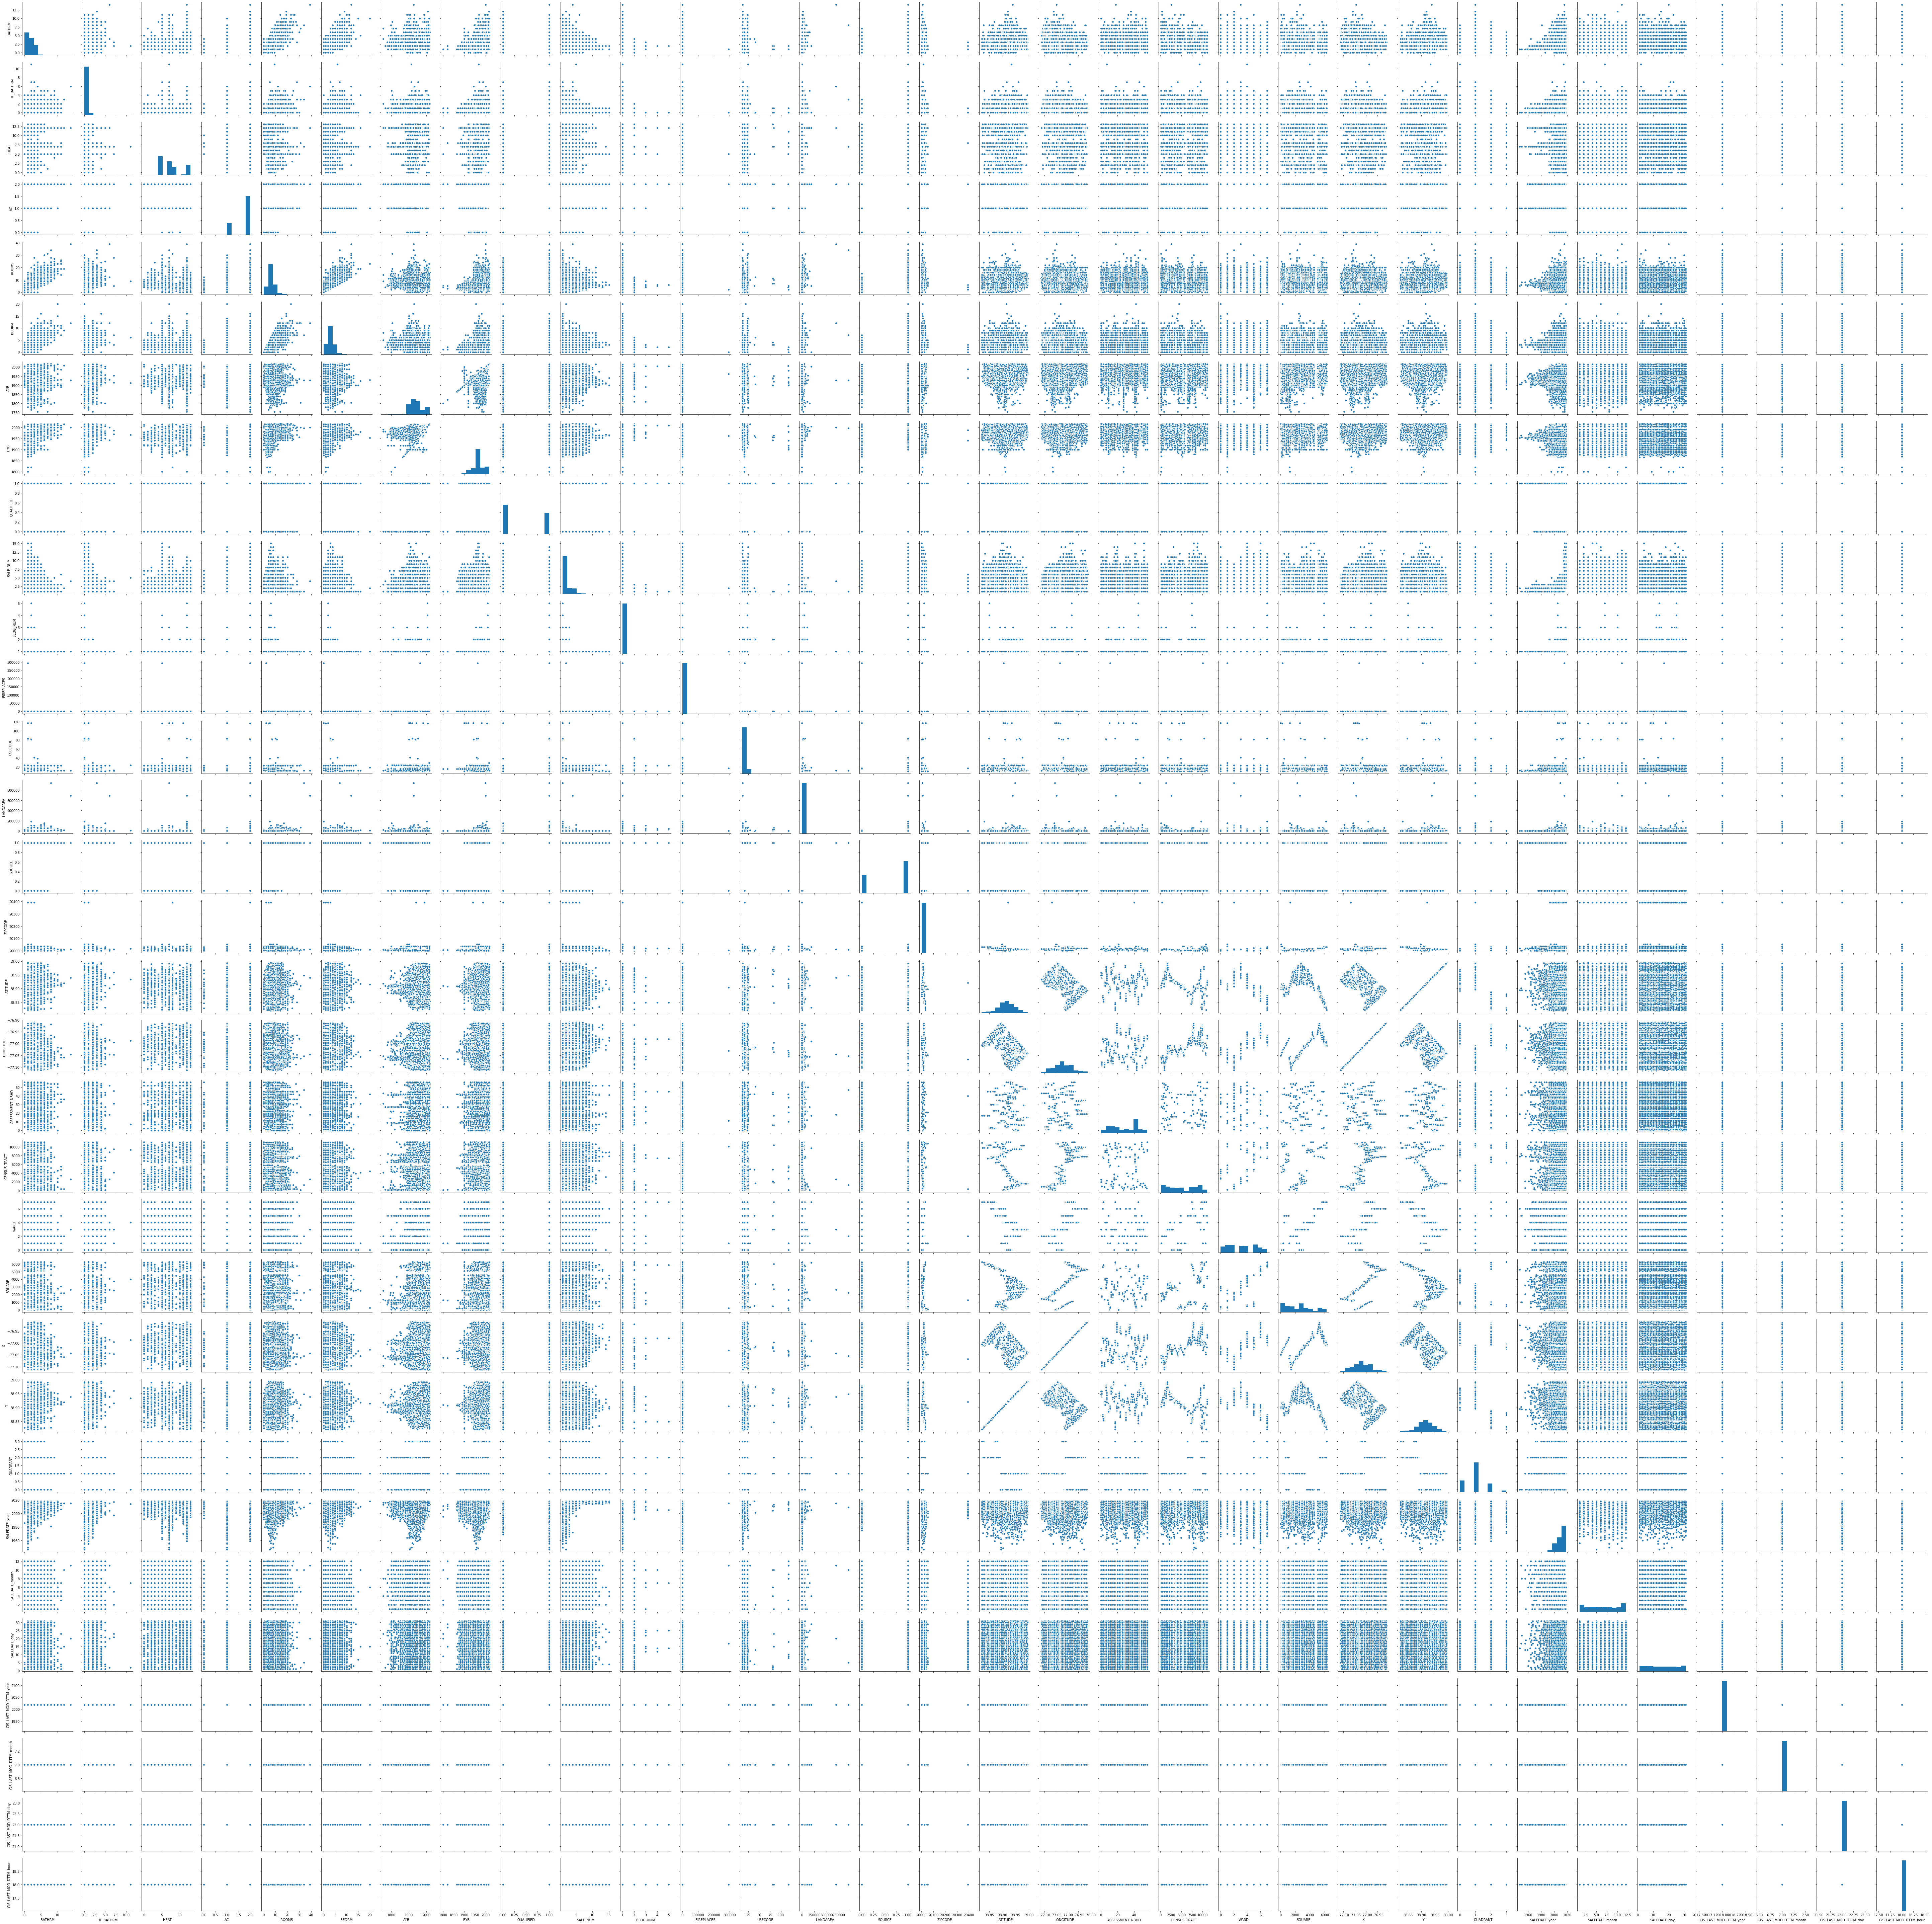

In [24]:
sns.pairplot(housing)

In [59]:
high_corr_var=np.where(housing_cor>0.8)
high_corr_var=[(housing_cor.columns[x],housing_cor.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [60]:
high_corr_var

[('ROOMS', 'BEDRM'), ('LATITUDE', 'Y'), ('LONGITUDE', 'X')]

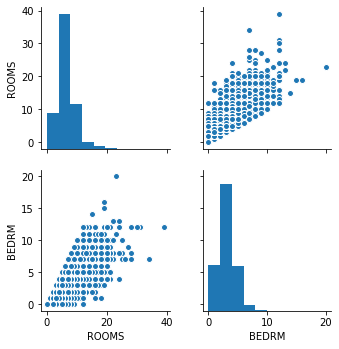

In [61]:
sns.pairplot(housing[['ROOMS',  'BEDRM']])

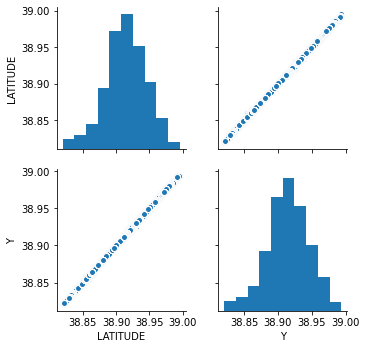

In [64]:
sns.pairplot(housing[['LATITUDE',  'Y']])

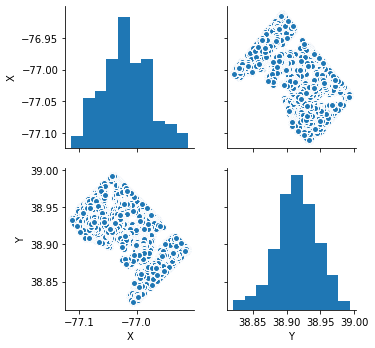

In [66]:
sns.pairplot(housing[['X',  'Y']])

In [44]:
drop_var = [(i[0]) for i in high_corr_var]

In [46]:
housing_new = housing.drop(columns=drop_var)

In [47]:
housing.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'ROOMS', 'BEDRM', 'AYB', 'EYB',
       'QUALIFIED', 'SALE_NUM', 'BLDG_NUM', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'SOURCE', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'CENSUS_TRACT', 'WARD', 'SQUARE', 'X', 'Y',
       'QUADRANT', 'SALEDATE_year', 'SALEDATE_month', 'SALEDATE_day',
       'GIS_LAST_MOD_DTTM_year', 'GIS_LAST_MOD_DTTM_month',
       'GIS_LAST_MOD_DTTM_day', 'GIS_LAST_MOD_DTTM_hour'],
      dtype='object')

<AxesSubplot:>

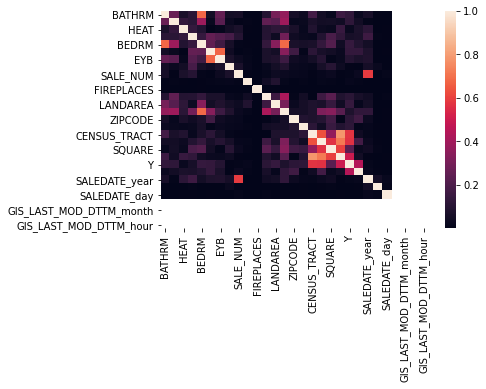

In [51]:
housing_new_cor = housing_new.corr().abs()
sns.heatmap(housing_new_cor)

In [54]:
high_corr_var=np.where(housing_new_cor>0.8)
high_corr_var=[(housing_cor.columns[x],housing_cor.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [55]:
high_corr_var

[]